# Инициализация

Загружаем библиотеки необходимые для выполнения кода ноутбука.

In [1]:
import pandas as pd
from implicit.als import AlternatingLeastSquares
from scipy.sparse import coo_matrix
import numpy as np

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# === ЭТАП 1 ===

# Загрузка первичных данных

Загружаем первичные данные из файлов:
- tracks.parquet
- catalog_names.parquet
- interactions.parquet

In [2]:
tracks = pd.read_parquet("tracks.parquet")
catalog_names = pd.read_parquet("catalog_names.parquet")
interactions = pd.read_parquet("interactions.parquet")

print("tracks:", tracks.columns)
print("catalog_names:", catalog_names.columns)
print("interactions:", interactions.columns)

print(tracks.head())
print("* "*20)
print(catalog_names.head())
print("* "*20)
print(interactions.head())


tracks: Index(['track_id', 'albums', 'artists', 'genres'], dtype='object')
catalog_names: Index(['id', 'type', 'name'], dtype='object')
interactions: Index(['user_id', 'track_id', 'track_seq', 'started_at'], dtype='object')
   track_id                                             albums artists  \
0        26                                       [3, 2490753]    [16]   
1        38                                       [3, 2490753]    [16]   
2       135                                 [12, 214, 2490809]    [84]   
3       136                                 [12, 214, 2490809]    [84]   
4       138  [12, 214, 322, 72275, 72292, 91199, 213505, 24...    [84]   

     genres  
0  [11, 21]  
1  [11, 21]  
2      [11]  
3      [11]  
4      [11]  
* * * * * * * * * * * * * * * * * * * * 
   id   type               name
0   3  album    Taller Children
1  12  album  Wild Young Hearts
2  13  album      Lonesome Crow
3  17  album      Graffiti Soul
4  26  album     Blues Six Pack
* * * * * * * 

# Обзор данных

Проверяем данные, есть ли с ними явные проблемы.

In [3]:
print("=== tracks ===")
print("Пропуски:\n", tracks.isnull().sum())
print("Дубликатов по 'track_id':", tracks.duplicated(subset=['track_id']).sum())

print("\n=== catalog_names ===")
print("Пропуски:\n", catalog_names.isnull().sum())
print("Дубликатов по ['id', 'type']:", catalog_names.duplicated(subset=['id', 'type']).sum())

print("\n=== interactions ===")
print("Пропуски:\n", interactions.isnull().sum())
print("Дубликатов по ['user_id', 'track_id', 'started_at']:", interactions.duplicated(subset=['user_id', 'track_id', 'started_at']).sum())
print("Диапазон дат started_at:\n", interactions['started_at'].min(), "-", interactions['started_at'].max())

print("tracks - track_id:", tracks["track_id"].dtype)
print("catalog_names - id:", catalog_names["id"].dtype)
print("interactions - track_id:", interactions["track_id"].dtype)
print("interactions - user_id:", interactions["user_id"].dtype)
print("interactions - started_at:", interactions["started_at"].dtype)

=== tracks ===
Пропуски:
 track_id    0
albums      0
artists     0
genres      0
dtype: int64
Дубликатов по 'track_id': 0

=== catalog_names ===
Пропуски:
 id      0
type    0
name    0
dtype: int64
Дубликатов по ['id', 'type']: 0

=== interactions ===
Пропуски:
 user_id       0
track_id      0
track_seq     0
started_at    0
dtype: int64
Дубликатов по ['user_id', 'track_id', 'started_at']: 0
Диапазон дат started_at:
 2022-01-01 00:00:00 - 2022-12-31 00:00:00
tracks - track_id: int64
catalog_names - id: int64
interactions - track_id: int32
interactions - user_id: int32
interactions - started_at: datetime64[ns]


In [4]:
print(tracks["track_id"].head(2))
print(catalog_names["id"].head(2))
print(interactions["user_id"].head(2))

0    26
1    38
Name: track_id, dtype: int64
0     3
1    12
Name: id, dtype: int64
0    0
1    0
Name: user_id, dtype: int32


# Выводы

Приведём выводы по первому знакомству с данными:
- есть ли с данными явные проблемы,
- какие корректирующие действия (в целом) были предприняты.

In [5]:
#данные чистые, все айди в одном типе данных

# === ЭТАП 2 ===

# EDA

Распределение количества прослушанных треков.

<Axes: >

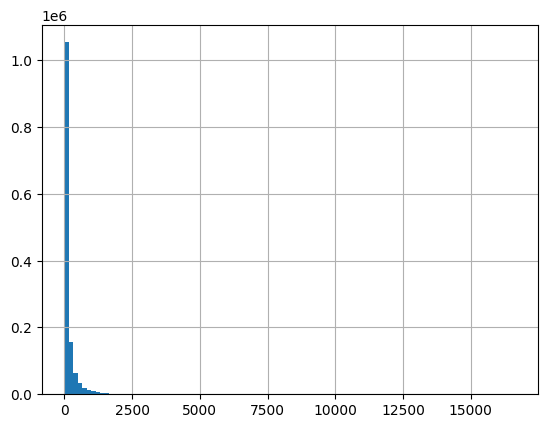

In [6]:
track_counts_per_user = interactions.groupby("user_id")["track_id"].count()
track_counts_per_user.hist(bins=100)

Наиболее популярные треки

In [7]:
top_tracks = interactions["track_id"].value_counts().head(10)
print(top_tracks)


track_id
53404       111062
33311009    106921
178529      101924
35505245     99490
65851540     86670
24692821     86246
32947997     85886
51241318     85244
795836       85042
45499814     84748
Name: count, dtype: int64


Наиболее популярные жанры

In [8]:
from collections import Counter

all_genres = tracks["genres"].explode()
genre_counts = all_genres.value_counts().head(10)
print(genre_counts)


genres
11     166285
75     128212
102    118509
68     114245
47      72311
3       65958
44      59778
14      55177
16      51631
20      46707
Name: count, dtype: int64


Треки, которые никто не прослушал

In [9]:
all_track_ids = set(tracks["track_id"])
used_track_ids = set(interactions["track_id"])
unused_track_ids = all_track_ids - used_track_ids

print("Неиспользованных треков:", len(unused_track_ids))


Неиспользованных треков: 0


In [10]:
#Отрезок времени
#print(min(interactions["started_at"]))
#print(max(interactions["started_at"]))

# Преобразование данных


Преобразуем данные в формат, более пригодный для дальнейшего использования в расчётах рекомендаций.

# Сохранение данных

Сохраним данные в двух файлах в персональном S3-бакете по пути `recsys/data/`:
- `items.parquet` — все данные о музыкальных треках,
- `events.parquet` — все данные о взаимодействиях.

In [11]:
#items = tracks.rename(columns={
#    "track_id": "item_id"
#})
#items.to_parquet("items.parquet", index=False)
#
#events = interactions.rename(columns={
#    "track_id": "item_id",
#    "started_at": "event_timestamp"
#})
#events.to_parquet("events.parquet", index=False)


# Очистка памяти

Здесь, может понадобится очистка памяти для высвобождения ресурсов для выполнения кода ниже. 

Приведите соответствующие код, комментарии, например:
- код для удаление более ненужных переменных,
- комментарий, что следует перезапустить kernel, выполнить такие-то начальные секции и продолжить с этапа 3.

In [12]:
del tracks
del catalog_names
del interactions
del track_counts_per_user
del top_tracks
del all_genres
del genre_counts
del all_track_ids
del used_track_ids
del unused_track_ids

# === ЭТАП 3 ===

# Загрузка данных

Если необходимо, то загружаем items.parquet, events.parquet.

In [13]:
events = pd.read_parquet("events.parquet")
items = pd.read_parquet("items.parquet")

# Разбиение данных

Разбиваем данные на тренировочную, тестовую выборки.

In [14]:
cutoff_time = pd.Timestamp("2022-12-16")
train_events = events[events["event_timestamp"] < cutoff_time]
test_events = events[events["event_timestamp"] >= cutoff_time]

# Топ популярных

Рассчитаем рекомендации как топ популярных.

In [15]:
top_items = train_events["item_id"].value_counts().head(20).index.tolist()
print("Топ популярных треков:", top_items)

Топ популярных треков: [53404, 33311009, 178529, 35505245, 24692821, 795836, 6705392, 32947997, 37384, 45499814, 51241318, 29544272, 39257277, 2758009, 65851540, 328683, 60292250, 17079396, 47627256, 51516485]


# Персональные

Рассчитаем персональные рекомендации.

In [16]:
user_ids = train_events["user_id"].astype("category")
item_ids = train_events["item_id"].astype("category")

train_events["user_id_enc"] = user_ids.cat.codes
train_events["item_id_enc"] = item_ids.cat.codes

user_item_matrix = coo_matrix((
    np.ones(len(train_events)),
    (train_events["user_id_enc"], train_events["item_id_enc"])
))

/tmp/ipykernel_2630/749614942.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_events["user_id_enc"] = user_ids.cat.codes
/tmp/ipykernel_2630/749614942.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_events["item_id_enc"] = item_ids.cat.codes


In [ ]:
# als_model = AlternatingLeastSquares(factors=16, iterations=10, random_state=42)
# als_model.fit(user_item_matrix)

# user_id_map = dict(enumerate(user_ids.cat.categories))
# item_id_map = dict(enumerate(item_ids.cat.categories))

# user_item_csr = user_item_matrix.tocsr()

/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/cpu/als.py:95: RuntimeWarning: OpenBLAS is configured to use 4 threads. It is highly recommended to disable its internal threadpool by setting the environment variable 'OPENBLAS_NUM_THREADS=1' or by calling 'threadpoolctl.threadpool_limits(1, "blas")'. Having OpenBLAS use a threadpool can lead to severe performance issues here.
  check_blas_config()
/home/mle-user/mle_projects/mle-project-sprint-4-v001/env_recsys_start/lib/python3.10/site-packages/implicit/utils.py:164: ParameterWarning: Method expects CSR input, and was passed coo_matrix instead. Converting to CSR took 1.7861101627349854 seconds
  warnings.warn(
100%|██████████| 10/10 [06:16<00:00, 37.60s/it]


In [18]:
import pickle

In [ ]:
# with open("als_model.pkl", "wb") as f:
#     pickle.dump(als_model, f)
from scipy.sparse import save_npz, load_npz
#save_npz("user_item_csr.npz", user_item_csr)
user_item_csr = load_npz("user_item_csr.npz")

In [20]:
from implicit.als import AlternatingLeastSquares
from scipy.sparse import load_npz
user_item_csr = load_npz("user_item_csr.npz")

with open("als_model.pkl", "rb") as f:
    als_model = pickle.load(f)

In [22]:
# all_recs = []
# for user in range(user_item_csr.shape[0]):
#     recs = als_model.recommend(
#         userid=user,
#         user_items=user_item_csr,
#         N=5,
#         filter_already_liked_items=False
#     )
#     all_recs.append(recs)

In [23]:
#rows = []
#for user, recs in enumerate(all_recs):
#    for rec in recs:
#        item_id = rec[0]
#        score = rec[1]
#        rows.append((user, item_id, score))
#
#df = pd.DataFrame(rows, columns=["user_id", "item_id", "score"])
#df.to_parquet("recommendations.parquet", index=False)


In [24]:
recommendations_df = pd.read_parquet("recommendations.parquet")

In [25]:
#recommendations = []
#for user_enc, recs in enumerate(all_recs):
#    for item_enc, score in zip(recs[0], recs[1]): 
#        recommendations.append({
#            "user_id": user_id_map[user_enc],
#            "item_id": item_id_map[item_enc],
#            "score": float(score)
#        })
#
#personal_recs = pd.DataFrame(recommendations)
#personal_recs.to_parquet("personal_als.parquet", index=False)


In [26]:
personal_als_df = pd.read_parquet("personal_als.parquet")

# Похожие

Рассчитаем похожие, они позже пригодятся для онлайн-рекомендаций.

In [27]:
#item_id_map = dict(enumerate(item_ids.cat.categories))
#
#similar_items = []
#for item_enc in range(len(item_id_map)):
#    sims = als_model.similar_items(item_enc, N=11)
#    for row in sims[1:]:  
#        sim_item_enc = int(row[0])
#        score = float(row[1])
#        similar_items.append({
#            "item_id": item_id_map[item_enc],
#            "similar_item_id": item_id_map[sim_item_enc],
#            "score": score
#        })
#
#similar_df = pd.DataFrame(similar_items)
#similar_df.to_parquet("similar.parquet", index=False)


In [28]:
similar_df = pd.read_parquet("similar.parquet")

# Построение признаков

Построим три признака, можно больше, для ранжирующей модели.

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [30]:
print(personal_als_df.columns)
print(similar_df.columns)
print(recommendations_df.columns)


Index(['user_id', 'item_id', 'score'], dtype='object')
Index(['item_id', 'similar_item_id', 'score'], dtype='object')
Index(['user_id', 'item_id', 'score'], dtype='object')


In [31]:
# features = personal_als_df.copy()
# features = features.rename(columns={"score": "als_score"})

# features = features.merge(
#     similar_df.rename(columns={
#         "similar_item_id": "rec_item_id",
#         "score": "similar_score"
#     }),
#     on="item_id",
#     how="left"
# )

# features = features.merge(
#     recommendations_df.rename(columns={"score": "rec_score"}),
#     on=["user_id", "item_id"],
#     how="left"
# )

# features["final_score"] = (
#     features["als_score"].fillna(0) * 0.6 +
#     features["similar_score"].fillna(0) * 0.3 +
#     features["rec_score"].fillna(0) * 0.1
# )

# ranked_recs = (
#     features.sort_values(["user_id", "final_score"], ascending=[True, False])
#     .groupby("user_id")
#     .head(100)
# )

# ranked_recs.to_parquet("recommendationsPERSONAL.parquet", index=False)

# print("Файл recommendationsPERSONAL.parquet перезаписан.")
# print(ranked_recs.head(10))


In [32]:
recommendationsPERS = pd.read_parquet("recommendationsPERSONAL.parquet")

# Ранжирование рекомендаций

Построим ранжирующую модель, чтобы сделать рекомендации более точными. Отранжируем рекомендации.

In [38]:
ranked_recs = pd.read_parquet("recommendationsPERSONAL.parquet")

In [39]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMRanker

user_ids = ranked_recs["user_id"].unique()
train_users, test_users = train_test_split(user_ids, test_size=0.2, random_state=42)

train_data = ranked_recs[ranked_recs["user_id"].isin(train_users)]
test_data = ranked_recs[ranked_recs["user_id"].isin(test_users)]

In [40]:
X_train = train_data[["als_score", "similar_score", "rec_score", "final_score"]]
y_train = (train_data["final_score"].rank(method="first", ascending=False) <= len(train_data) * 0.2).astype(int)

X_test = test_data[["als_score", "similar_score", "rec_score", "final_score"]]
y_test = (test_data["final_score"].rank(method="first", ascending=False) <= len(test_data) * 0.2).astype(int)

train_groups = train_data.groupby("user_id").size().to_list()
test_groups = test_data.groupby("user_id").size().to_list()


In [41]:
ranker = LGBMRanker(
    objective="lambdarank",
    metric="ndcg",
    boosting_type="gbdt",
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=100
)

ranker.fit(
    X_train, y_train,
    group=train_groups,
    eval_set=[(X_test, y_test)],
    eval_group=[test_groups],
    eval_at=[5, 10]
)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.593152 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 741
[LightGBM] [Info] Number of data points in the train set: 5370260, number of used features: 4


LGBMRanker(learning_rate=0.05, metric='ndcg', objective='lambdarank')

In [42]:
test_data["pred_score"] = ranker.predict(X_test)

ranked_final = (
    test_data.sort_values(["user_id", "pred_score"], ascending=[True, False])
    .groupby("user_id")
    .head(100)
)

ranked_final.to_parquet("recommendations_ranked.parquet", index=False)
print("Файл recommendations_ranked.parquet сохранён.")
print(ranked_final.head(10))

/tmp/ipykernel_2630/3714711879.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data["pred_score"] = ranker.predict(X_test)


Файл recommendations_ranked.parquet сохранён.
    user_id   item_id  als_score  rec_item_id  similar_score  rec_score  \
25        5    178529   0.223985           38       0.864941        NaN   
26        5    148345   0.188855           38       0.925949        NaN   
27        5     37384   0.199281           38       0.260346        NaN   
28        5     53404   0.254303           38       0.133883        NaN   
29        5   2758009   0.180657           38       0.044061        NaN   
35        7  52380688   0.023206           38       0.727476        NaN   
36        7  65851540   0.021966           26       0.630653        NaN   
37        7  62244864   0.018125           26       0.505802        NaN   
38        7  66869588   0.018628           38       0.178692        NaN   
39        7  49961817   0.020279           38       0.155754        NaN   

    final_score  pred_score  
25     0.393873    5.396156  
26     0.391098    5.396156  
27     0.197672   -5.385791  
28     0

# Оценка качества

Проверим оценку качества трёх типов рекомендаций: 

- топ популярных,
- персональных, полученных при помощи ALS,
- итоговых
  
по четырем метрикам: recall, precision, coverage, novelty.

In [44]:
true_df = test_events[["user_id", "item_id"]]
all_items = train_events["item_id"].unique()

item_popularity = (
    train_events["item_id"].value_counts(normalize=True)
    .rename_axis("item_id")
    .reset_index(name="popularity")
)

def precision(recs, true):
    merged = recs.merge(true, on=["user_id", "item_id"])
    p = merged.groupby("user_id").size() / recs.groupby("user_id").size()
    return p.mean()

def recall(recs, true):
    merged = recs.merge(true, on=["user_id", "item_id"])
    r = merged.groupby("user_id").size() / true.groupby("user_id").size()
    return r.mean()

def coverage(recs, all_items):
    return recs["item_id"].nunique() / len(all_items)

def novelty(recs, item_popularity):
    merged = recs.merge(item_popularity, on="item_id", how="left")
    return -np.mean(np.log2(merged["popularity"] + 1e-9))

popular_recs = (
    pd.DataFrame({"item_id": top_items})
    .assign(key=1)
    .merge(test_events[["user_id"]].drop_duplicates().assign(key=1), on="key")
    .drop("key", axis=1)
)

als_recs = personal_als_df[["user_id", "item_id"]]
final_recs = ranked_recs[["user_id", "item_id"]]

results = []
for name, recs in {
    "Популярные": popular_recs,
    "ALS": als_recs,
    "Итоговые": final_recs
}.items():
    res = {
        "Модель": name,
        "Precision": precision(recs, true_df),
        "Recall": recall(recs, true_df),
        "Coverage": coverage(recs, all_items),
        "Novelty": novelty(recs, item_popularity)
    }
    results.append(res)

results_df = pd.DataFrame(results)
results_df


,Модель,Precision,Recall,Coverage,Novelty
0,Популярные,0.069108,0.104127,0.000020,11.32014
1,ALS,0.232275,0.165523,0.000989,11.85998
2,Итоговые,0.232275,0.165523,0.000989,11.85998


# === Выводы, метрики ===

Основные выводы при работе над расчётом рекомендаций, рассчитанные метрики.